# [STEP1]Import需要的libary

In [1]:
import os
import re
import requests
import sys
import json
from bs4 import BeautifulSoup
import ddddocr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import six
import csv

# [STEP2]從網站爬蟲獲取資料

In [2]:
#宣告OCR物件
ocr = ddddocr.DdddOcr()

#重複執行直到驗證通過
while True:
    #宣告Session物件
    session = requests.Session()
    #設定目標網址
    resp = session.get('https://bsr.twse.com.tw/bshtm/bsMenu.aspx', verify=False)

    #如果回應200代表請求成功
    if resp.status_code == 200:
        # 使用 BeautifulSoup 解析 html
        soup = BeautifulSoup(resp.text, 'lxml')
        # 取得所有 'input' 物件
        nodes = soup.select('input')
        # 將欲傳送的資料存至 dictionary 當中
        params = {}
        for node in nodes:
            name = node.attrs['name']

            if name in ('RadioButton_Excd', 'Button_Reset'):
                continue

            if 'value' in node.attrs:
                params[node.attrs['name']] = node.attrs['value']
            else:
                params[node.attrs['name']] = ''

        # 取得圖片物件
        captcha_image = soup.select('#Panel_bshtm img')[0]['src']
        m = re.search(r'guid=(.+)', captcha_image)
        if m is None:
            exit(1)

        # 圖片存檔
        imgpath = '%s.jpg' % m.group(1)
        url = 'https://bsr.twse.com.tw/bshtm/' + captcha_image
        resp = requests.get(url, verify=False)
        if resp.status_code == 200:
            with open(imgpath, 'wb') as f:
                f.write(resp.content)
            os.system('open ' + imgpath)
            f.close()

        with open(imgpath, 'rb') as f:
            img_bytes = f.read()

        #利用OCR辨識圖片
        vcode = ocr.classification(img_bytes)
        f.close()

        # 圖片刪除
        try:
            os.remove(imgpath)
        except:
            pass
        params['CaptchaControl1'] = vcode

        #股票代碼
        params['TextBox_Stkno'] = '2317'

        #送出資料
        resp = session.post('https://bsr.twse.com.tw/bshtm/bsMenu.aspx', data=params)
        if resp.status_code != 200:
            print('任務失敗: %d' % resp.status_code)
            continue

        #利用BeautifulSoup解析HTML
        soup = BeautifulSoup(resp.text, 'lxml')
        nodes = soup.select('#HyperLink_DownloadCSV')
        if len(nodes) == 0:
            print('任務失敗，沒有下載連結')
            continue

        #下載卷商分點進出CSV
        resp = session.get('https://bsr.twse.com.tw/bshtm/bsContent.aspx')
        with open('output.csv', 'w', encoding="utf-8") as f:
            writer = csv.writer(f)
            for resp_line in resp.text.split('\n')[2:]:
                a = resp_line.split(',')
                # print(a)
                if len(a) >= 4:
                    a[1] = re.sub(r'[0-9A-Za-z ]+', '', a[1])
                    if len(a) >= 10:
                        a[7] = re.sub(r'[0-9A-Za-z ]+', '', a[7])
                    writer.writerow(a)
            f.close()

        if resp.status_code != 200:
            print('任務失敗，無法下載卷商分點進出 CSV')
            continue
        break


欢迎使用ddddocr，本项目专注带动行业内卷，个人博客:wenanzhe.com
训练数据支持来源于:http://146.56.204.113:19199/preview
爬虫框架feapder可快速一键接入，快速开启爬虫之旅：https://github.com/Boris-code/feapder
谷歌reCaptcha验证码 / hCaptcha验证码 / funCaptcha验证码商业级识别接口：https://yescaptcha.com/i/NSwk7i


# [STEP3]卷商分點資料處理

In [13]:
# 兩欄合併成一欄
data = pd.read_csv("output.csv")
combine_df = pd.DataFrame()
# 取出分點資料表的兩欄資料，並合併成一欄
df_left = data[['券商','價格','買進股數','賣出股數']]
df_right = data[['券商.1','價格.1','買進股數.1','賣出股數\r']]
df_right = df_right.rename(columns={"券商.1": "券商", "價格.1": "價格", "買進股數.1": "買進股數", '賣出股數\r': "賣出股數"})
combine_df = pd.concat([df_left, df_right], axis=0)
combine_df = combine_df.sort_values(["券商"], ascending=True, ignore_index=True)
combine_df = combine_df.dropna(axis=0, how='any')
combine_df['價格'] = combine_df['價格'].astype(float)
combine_df['買進股數'] = combine_df['買進股數'].astype(float)
combine_df['賣出股數'] = combine_df['賣出股數'].astype(float)
print(combine_df)

# 針對買進、賣出、買超、均買價、均賣價進行計算
temp = pd.DataFrame()
# 計算買進張數，每張為買進股數之千分之一
temp["買進"] = combine_df.groupby(by='券商').apply(lambda x: (x['買進股數']/1000).sum())
# 計算賣出張數，每張為賣出股數之千分之一
temp["賣出"] = combine_df.groupby(by='券商').apply(lambda x: (x['賣出股數']/1000).sum())
# 計算買超張數，買超為(買進股數-賣出股數)之千分之一
temp["買超"] = combine_df.groupby(by='券商').apply(lambda x: ((x['買進股數'] - x['賣出股數'])/1000).sum())
# 計算均買價，均買價為當日買進總價除以當日買進的總股數
temp["均買價"] = combine_df.groupby(by='券商').apply(lambda x: (x['買進股數']/1000 * x['價格']).sum()/(x['買進股數']/1000).sum())
# 計算均賣價，均賣價為當日賣出總價除以當日賣出的總股數
temp["均賣價"] = combine_df.groupby(by='券商').apply(lambda x: (x['賣出股數']/1000 * x['價格']).sum()/(x['賣出股數']/1000).sum())

        券商     價格     買進股數     賣出股數
0       ?亞  100.5   2000.0      0.0
1       ?亞  101.0   1000.0      0.0
2       ?亞  100.0   1000.0  25000.0
3     ?亞網路  100.0  34000.0   1000.0
4     ?亞網路  101.0  11000.0      0.0
...    ...    ...      ...      ...
3562  高橋龍潭  101.0  33000.0   1000.0
3563  高橋龍潭  102.0   1000.0      0.0
3564  高橋龍潭  101.5   2100.0      0.0
3565  高橋龍潭  100.5  40200.0   1000.0
3566  高橋龍潭  100.0  38000.0   4000.0

[3567 rows x 4 columns]


In [14]:
temp.head()

,買進,賣出,買超,均買價,均賣價
券商,,,,,
?亞,4.000,25.0,-21.000,100.500000,100.000000
?亞網路,65.810,12.0,53.810,100.522793,101.208333
?亞鑫豐,336.833,147.0,189.833,100.429861,101.078231
上海匯豐,0.000,71.0,-71.000,NaN,101.176056
中信三重,87.420,46.0,41.420,100.524823,100.489130


In [15]:
temp.reset_index()

,券商,買進,賣出,買超,均買價,均賣價
0,?亞,4.000,25.0,-21.000,100.500000,100.000000
1,?亞網路,65.810,12.0,53.810,100.522793,101.208333
2,?亞鑫豐,336.833,147.0,189.833,100.429861,101.078231
3,上海匯豐,0.000,71.0,-71.000,NaN,101.176056
4,中信三重,87.420,46.0,41.420,100.524823,100.489130
...,...,...,...,...,...,...
843,陽信高雄,17.600,1.0,16.600,100.357955,100.500000
844,高橋,106.000,30.1,75.900,100.500000,100.470100
845,高橋中壢,11.000,10.0,1.000,100.590909,101.000000
846,高橋內壢,66.110,0.0,66.110,100.605884,NaN


In [16]:
temp.reset_index(level=None, drop=False, inplace=False, col_level=0, col_fill='')

,券商,買進,賣出,買超,均買價,均賣價
0,?亞,4.000,25.0,-21.000,100.500000,100.000000
1,?亞網路,65.810,12.0,53.810,100.522793,101.208333
2,?亞鑫豐,336.833,147.0,189.833,100.429861,101.078231
3,上海匯豐,0.000,71.0,-71.000,NaN,101.176056
4,中信三重,87.420,46.0,41.420,100.524823,100.489130
...,...,...,...,...,...,...
843,陽信高雄,17.600,1.0,16.600,100.357955,100.500000
844,高橋,106.000,30.1,75.900,100.500000,100.470100
845,高橋中壢,11.000,10.0,1.000,100.590909,101.000000
846,高橋內壢,66.110,0.0,66.110,100.605884,NaN


In [8]:
# 依照買超排序，並取出兩表(買超為正和買超為負的兩表)
temp = temp.reset_index(level=None, drop=False, inplace=False, col_level=0, col_fill='')
positive = temp[temp['買超'] >= 0]
positive = positive.sort_values(by='買超', ascending=False).reset_index()
negative = temp[temp['買超'] < 0]
negative = negative.sort_values(by='買超').reset_index()
del positive['index']
del negative['index']

# 將兩表合併，並儲存至csv
result_df = pd.concat([positive, negative], axis=1).round(2)
result_df.to_csv("result.csv")

In [9]:
positive.head()

,券商,買進,賣出,買超,均買價,均賣價
0,凱基台北,5806.229,4321.000,1485.229,100.677367,101.241032
1,新光,1647.637,596.851,1050.786,100.690502,100.479894
2,國泰敦南,1062.095,130.590,931.505,100.452875,100.570606
3,法銀巴黎,926.000,0.000,926.000,100.907127,NaN
4,富邦仁愛,665.654,30.115,635.539,101.110753,100.435248


In [10]:
negative.head()

,券商,買進,賣出,買超,均買價,均賣價
0,台灣匯立,33.000,15323.000,-15290.000,100.500000,100.512171
1,瑞銀,2549.960,11658.817,-9108.857,101.062558,100.937850
2,花旗環球,3527.000,12182.400,-8655.400,100.693649,100.088168
3,台灣摩根,689.448,6088.810,-5399.362,100.945385,100.689020
4,國泰綜合,392.828,2578.006,-2185.178,100.598143,100.321180


# [STEP4]使用matplotlib輸出卷商買賣結果

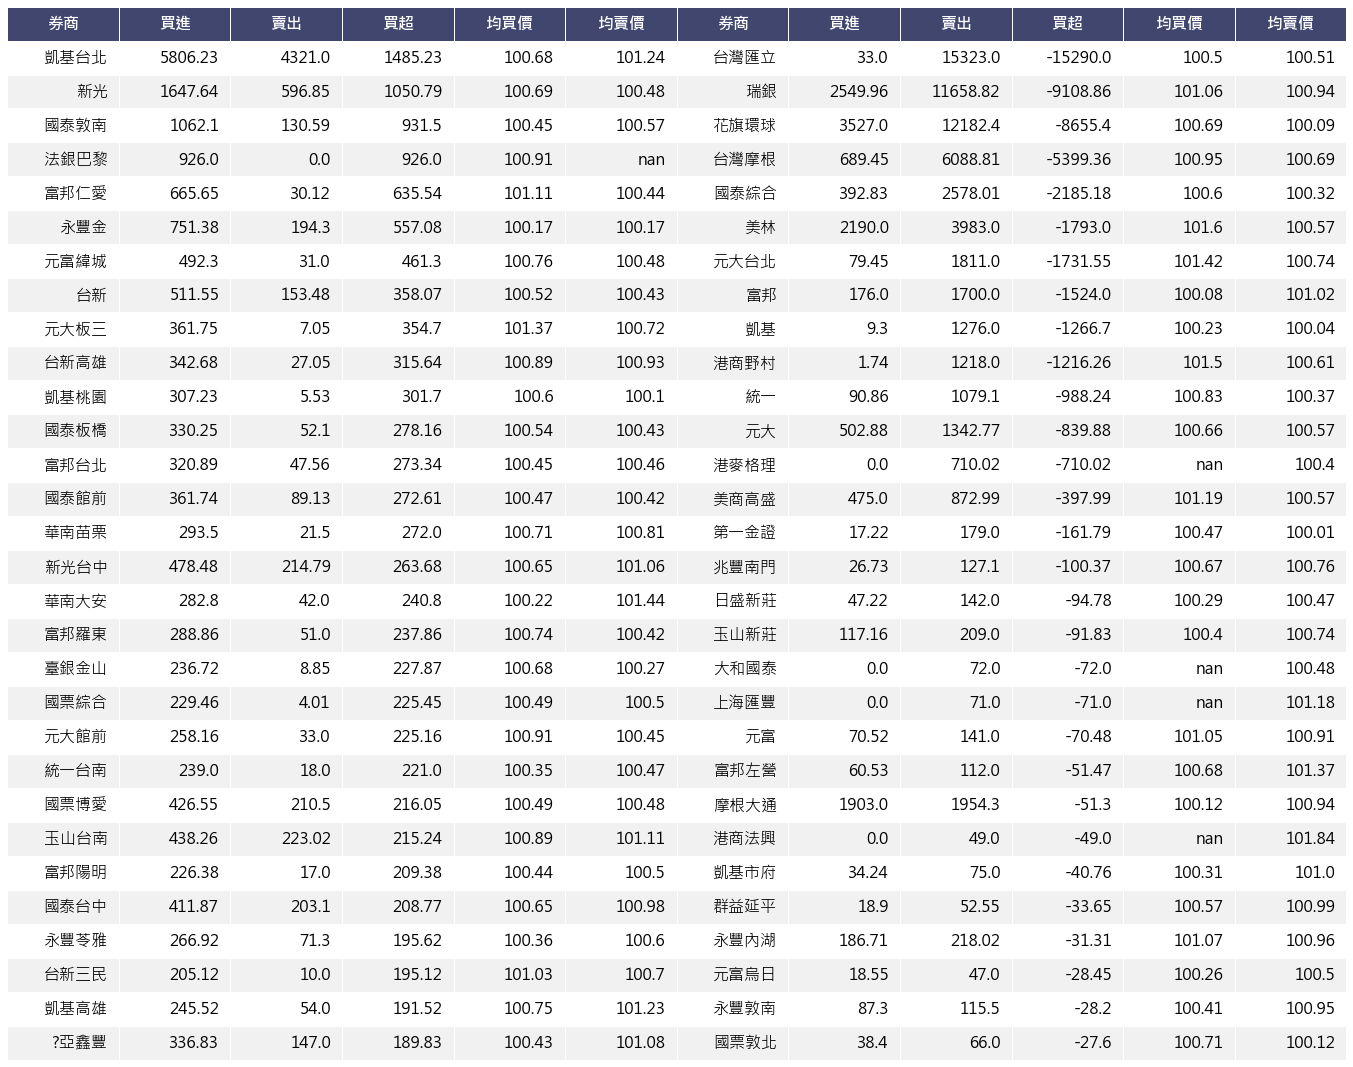

In [5]:
# 以下是繪圖用 

#設定matplotlib字體
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei']
plt.rcParams['axes.unicode_minus'] = False

def render_mpl_table(data, col_width=1.0, row_height=0.625, font_size=16,
                     header_color='#40466e', row_colors=['#f1f1f2', 'w'], edge_color='w',
                     bbox=[0, 0, 1, 1], header_columns=0,
                     ax=None, **kwargs):
    if ax is None:
        size = (np.array(data.shape[::-1]) + np.array([0, 1])) * np.array([col_width, row_height])
        fig, ax = plt.subplots(figsize=size)
        ax.axis('off')

    mpl_table = ax.table(cellText=data.values, bbox=bbox, colLabels=data.columns, **kwargs)

    mpl_table.set_fontsize(font_size)
    mpl_table.auto_set_font_size(False)

    for k, cell in six.iteritems(mpl_table._cells):
        cell.set_edgecolor(edge_color)
        if k[0] == 0 or k[1] < header_columns:
            cell.set_text_props(weight='bold', color='w')
            cell.set_facecolor(header_color)
        else:
            cell.set_facecolor(row_colors[k[0]%len(row_colors) ])
    return ax


def get_table(ax):
    table = None
    for child in ax.get_children():
        if isinstance(child, matplotlib.table.Table):
            table = child
            return table
    return table


def set_row_edge_color(ax, row, color):
    table = get_table(ax)
    for k, cell in six.iteritems(table._cells):
        if (k[0] == row):
            cell.set_edgecolor(color)


ax = render_mpl_table(result_df[:30], header_columns=0, col_width=2.0)
#set_row_edge_color(ax, 2, 'k')
# plt.tight_layout()
#plt.savefig("out.jpg")
plt.show()